# Intro

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sacc
import pyccl as ccl
import astropy.table as tbl
import os
import emcee
from scipy.optimize import minimize
import corner
import pickle

In [2]:
nEbins = 1 # Number of energy bins
nzbins = 12 # Number of galaxy redshift bins
nls = 7 # Number of cl data points
sacc_path = 'cl_flux_number.fits' # File containing sacc data

rker_z_min = 0.002 # Minimum redshift for neutrino radial kernel
rker_z_max = 0.6 # Maximum redshift for neutrino radial kernel
rker_z_n = 1024 # Number of redshift/radial distance values in neutrino radial kernel
gal_z_dir = ['../GalZDist', '../GalZDist_2']  # Directory containing redshift distributions of each galaxy map
bzs = [1.182, 1.086, 1.126, 1.144, 1.206, 1.548, 
       1.13, 1.40, 1.35, 1.77, 2.1, 2.5] # Bias values for each galaxy map

A_prior = 0.1 # Maximum absolute value of A in top-hat prior (not currently used)
alpha_prior = 5 # Maximum absolute value of alpha in top-hat prior

include_first_ell = False # Whether to include first data point

fixed_alpha = True # Whether to fix alpha value
npars = 2 # Number of free parameters in MCMC sampling
if fixed_alpha:
    alpha_val = -1 # Value to fix alpha at
    npars = 1 # Number of parameters to use in MCMC sampling

run_mcmc = False # Whether to run MCMC (True) or load pre-ran samplers from disk (False)
nwalkers = 8 # Number of walkers in MCMC sampling
nsamples = 10000 # Number of samples in MCMC sampling
if include_first_ell:
    mcmc_chain_dir = 'MCMCChains_fn' # Directory containing MCMC samplers
    mcmc_plots_dir = 'MCMCPlots_fn' # Directory to save MCMC plots to
else:
    mcmc_chain_dir = 'MCMCChains_fn_nol2' # Directory containing MCMC samplers
    mcmc_plots_dir = 'MCMCPlots_fn_nol2' # Directory to save MCMC plots to

write_to_file = False # Whether to write results to file

perform_sing_test = False # Whether to perform tests on singular cross-correlation
sing_test = [0,0] # Singular cross-correlation to test
sing_A_prior = 0.1 # Maximum absolute value of A in top-hat prior
sing_alpha_prior = 100 # Maximum absolute value of alpha in top-hat prior

# xCell Power Spectra (Data)

In [3]:
# Loads in data, only keeps first 7 data points to match previous calculations
s = sacc.Sacc.load_fits(sacc_path)
s.remove_selection(ell__gt=352)

In [4]:
s.get_tracer_combinations()

[('LOWZ__0', 'IceCubeY10'),
 ('LOWZ__1', 'IceCubeY10'),
 ('LOWZ__10', 'IceCubeY10'),
 ('LOWZ__11', 'IceCubeY10'),
 ('LOWZ__2', 'IceCubeY10'),
 ('LOWZ__3', 'IceCubeY10'),
 ('LOWZ__4', 'IceCubeY10'),
 ('LOWZ__5', 'IceCubeY10'),
 ('LOWZ__6', 'IceCubeY10'),
 ('LOWZ__7', 'IceCubeY10'),
 ('LOWZ__8', 'IceCubeY10'),
 ('LOWZ__9', 'IceCubeY10')]

In [5]:
# Finds relevant indices in sacc object
indices = []
for i in range(nEbins):
    indices.append([])
    for j in range(nzbins):
        ind_here = s.indices('cl_00', (f'LOWZ__{j}', 'IceCubeY10'))
        if include_first_ell:
            indices[i] += list(ind_here)
        else:
            indices[i] += list(ind_here)[1:]
indices = np.array(indices)

# Gets ells, cls, covs, and inverse covs
ells, _ = s.get_ell_cl('cl_00', 'LOWZ__0', 'IceCubeY10')
if not include_first_ell:
    ells = ells[1:]
cls = np.array([s.mean[ind] for ind in indices])
cov_total = s.covariance.covmat
covs = np.array([cov_total[ind][:, ind] for ind in indices])
icovs = np.array([np.linalg.inv(cov) for cov in covs])

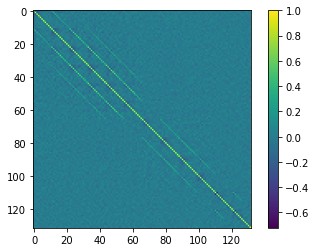

In [6]:
for cov in covs:
    plt.figure()
    r = cov/np.sqrt(np.diag(cov)[:, None]*np.diag(cov)[None, :])
    plt.imshow(r)
    plt.colorbar()

# Theoretical Power Spectra (Model)

In [7]:
# Sets cosmological model
cosmo = ccl.CosmologyVanillaLCDM(transfer_function='eisenstein_hu')

In [8]:
# Loads in galaxy redshift distributions into astropy tables
gal_z_filenames = sorted(os.listdir(gal_z_dir[0]))

gal_z_dist = []
for i in gal_z_filenames:
    gal_z_dist.append(tbl.Table.read(gal_z_dir[0] + '/' + i, format = 'ascii'))

[gal_z_dist.append(tbl.Table.read(gal_z_dir[1]+f'/dndz_DELS__{i}_nuX.txt', 
                                  format = 'ascii')) for i in range(4)]
[gal_z_dist.append(tbl.Table.read(gal_z_dir[1]+f'/dndz_SDSS__QSO{i}_nuX.txt', 
                                  format = 'ascii')) for i in range(2)]

[None, None]

In [9]:
# Creates tracer for each galaxy redshift bin
gal_tracers = []
for i in range(len(gal_z_dist)):
    z = np.array(gal_z_dist[i]['col1'])
    nz = np.array(gal_z_dist[i]['col2'])
    bz = np.full(len(z), bzs[i])
    gal_tracers.append(ccl.NumberCountsTracer(cosmo, has_rsd=False, 
                                              dndz=(z, nz), bias=(z, bz)))

In [10]:
# Finds array of radial distances (chi) of radial kernel
chi_min = ccl.comoving_radial_distance(cosmo, 1./(1+rker_z_min))
chi_max = ccl.comoving_radial_distance(cosmo, 1./(1+rker_z_max))
chi_arr = np.linspace(chi_min, chi_max, rker_z_n)

# Converts radial distance array to inverse scale factor array (i.e. 1+z)
inv_a_arr = 1/ccl.scale_factor_of_chi(cosmo, chi_arr)

In [11]:
# Generates neutrino tracer
def generate_nu_tracer(cosmo, A, alpha=alpha_val, 
                       inv_a_arr=inv_a_arr):
    # cosmo - cosmological model to use
    # A - constant of proportionality in neutrino radial kernel
    # alpha - index of power in neutrino radial kernel
    # z_min - minimum redshift for neutrino radial kernel
    # z_max - maximum redshift for neutrino radial kernel
    # nchi - number of redshift/radial distance values in neutrino radial kernel

    # Uses chosen A and alpha to find final array of radial kernel
    rker_arr = A*(inv_a_arr)**alpha

    # Adds radial kernel to tracer
    nu_tracer = ccl.Tracer()
    nu_tracer.add_tracer(cosmo, kernel = (chi_arr, rker_arr))
    return nu_tracer

In [12]:
# Finds theoretical/model power spectra using neutrino radial kernel of the form A*(1+z)^alpha
def model(A, alpha=alpha_val):
    # A - constant of proportionality in neutrino radial kernel
    # alpha - index of power in neutrino radial kernel
    
    nu_tracer = generate_nu_tracer(cosmo, A, alpha)
    cl_cross = []
    for i in gal_tracers:
        cl_cross += list(ccl.angular_cl(cosmo, nu_tracer, i, ells))
    return np.array(cl_cross)

# Chi-squared

In [13]:
# Finds chi squared of given data and model
def chi2(p, d, icov, alpha_val=alpha_val):
    # p - parameters to use in model
    # d - cls of xCell data
    # icov - inverse covariance matrix of xCell data
    # alpha_val - fixed alpha value
    
    if len(p) == 2:
        A, alpha = p
    else:
        A = p
        alpha = alpha_val
    # Flat priors
    if np.fabs(alpha) > alpha_prior:
        return np.inf
    # Finds t and model
    t = model(1, alpha)
    mod = A*t
    # Calculates volume prior
    log_vol_prior = 0.5*np.log(np.dot(t, np.dot(icov, t)))
    # Calculates chi2
    r = (d-mod)
    chi2 = np.dot(r, np.dot(icov, r))
    
    return chi2-2*log_vol_prior

0 [-0.00351859] 184.21304817722483


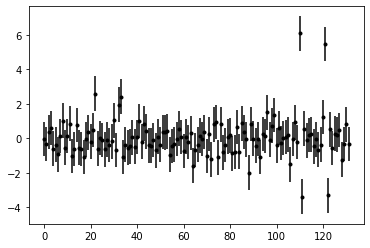

In [14]:
# Finds 'best fit' values of A, alpha for each cross-correlation
A_BF = np.empty(nEbins)
alpha_BF = np.empty(nEbins)

for i, (cl, icov, cov) in enumerate(zip(cls, icovs, covs)):
    if fixed_alpha:
        x = minimize(chi2, [1], args=(cl, icov), method='Powell').x
        A_BF[i] = x
        alpha_BF[i] = alpha_val
    else:
        x = minimize(chi2, [1, 1], args=(cl, icov), method='Powell').x
        A_BF[i], alpha_BF[i] = x
    print(i, x, chi2(x, cl, icov))
    plt.figure()
    plt.errorbar(np.arange(len(cl)), (cl-model(A_BF[i], alpha_BF[i]))/np.sqrt(np.diag(cov)),
                 yerr=np.ones_like(cl), fmt='k.')

# MCMC

In [15]:
if run_mcmc:
    sampler = []
    chain = []
    
    # For each cross-correlation
    for i in range(nEbins):
            
        if fixed_alpha:
            # Starting position of MCMC walkers
            pos = (A_BF[i] +
                   (1e-9) * np.random.randn(nwalkers, npars))
        else:
            # Starting position of MCMC walkers
            pos = ([A_BF[i], alpha_BF[i]] +
                   (1e-9, 1e-4) * np.random.randn(nwalkers, npars))

        # Creates MCMC sampler
        sampler.append(emcee.EnsembleSampler(nwalkers, npars, 
                                             lambda p: -0.5*chi2(p, cls[i], icovs[i])))

        # Runs MCMC and gets resulting chain (discarding first 20%, 'burn in' phase)
        sampler[i].run_mcmc(pos, nsamples)
        chain.append(sampler[i].get_chain(flat=True, discard=int(0.2*nsamples)).T)
        print(i)
    
    # Saves chains in pickle format
    with open(mcmc_chain_dir + '/MCMCChains', 'wb') as fp:
        pickle.dump(chain, fp)

else:
    # Loads chains from disk
    with open(mcmc_chain_dir + '/MCMCChains', 'rb') as fp:
        chain = pickle.load(fp)

# Plots

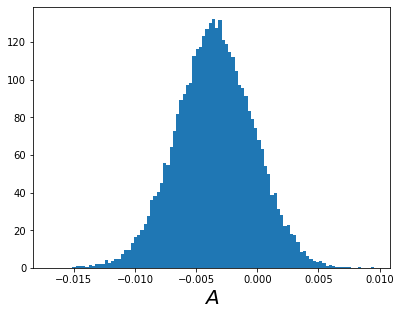

In [16]:
# Creates grid of subfigures
fig, axs = plt.subplots(nEbins, figsize = (6.4, 4.8*nEbins))

# Calculates chains and plots 2D histogram
for i in range(nEbins):
    if fixed_alpha:
        if nEbins == 1:
            axs.hist(chain[i][0], bins=100, density=True)
            axs.set_xlabel(r'$A$', fontsize=20);
        else:
            axs[i].hist(chain[i][0], bins=100, density=True)
            axs[i].set_xlabel(r'$A$', fontsize=20);
    else:
        if nEbins == 1:
            axs.scatter(chain[i][0], chain[i][1], c='k', s=1, alpha=0.1)
            axs.plot(A_BF[i], alpha_BF[i], 'yo', label='Best fit')
            axs.set_title(f'Energy bin {i}')
            axs.set_ylabel(r'$\alpha$', fontsize=20)
            axs.set_xlabel(r'$A$', fontsize=20)
            axs.legend()
        else:
            axs[i].scatter(chain[i][0], chain[i][1], c='k', s=1, alpha=0.1)
            axs[i].plot(A_BF[i], alpha_BF[i], 'yo', label='Best fit')
            axs[i].set_title(f'Energy bin {i}')
            axs[i].set_ylabel(r'$\alpha$', fontsize=20)
            axs[i].set_xlabel(r'$A$', fontsize=20)
            axs[i].legend()

if fixed_alpha:
    plt.savefig(mcmc_plots_dir + f'/MCMC1DHistogramfa{alpha_val}.pdf')
else:
    plt.savefig(mcmc_plots_dir + f'/MCMC2DHistogramAP{alpha_prior}.png')

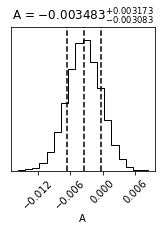

In [17]:
# Plots corner plots for each cross-correlation
for i in range(nEbins):
    corner.corner(chain[i].T, labels=['A','alpha'], quantiles=[0.16,0.5,0.84], 
                  show_titles=True, title_kwargs={'fontsize': 12}, title_fmt='.6f')
    if fixed_alpha:
        plt.savefig(mcmc_plots_dir + f'/MCMCCornerfa{alpha_val}E{i}.pdf')
    else:
        plt.savefig(mcmc_plots_dir + f'/MCMCCornerAP{alpha_prior}E{i}.pdf') 
    plt.show()

In [18]:
if write_to_file:
    with open('A_Constraints.txt', 'a+') as file_object:
        for i in range(nEbins):
            quantiles = corner.quantile(chain[i].T, [0.16,0.5,0.84])
            A_Constraints = f'{quantiles[1]} (+{quantiles[2]-quantiles[1]}, -{quantiles[1]-quantiles[0]})'
            # Move read cursor to the start of file
            file_object.seek(0)
            # If file is not empty then append '\n'
            data = file_object.read(100)
            if len(data) > 0 :
                file_object.write('\n')
                file_object.write('\n')
            # Append text at the end of file
            file_object.write(f'file: {sacc_path}, z bin: all, includes first ell: {include_first_ell}, ' +
                              f'[0.16,0.5,0.84] quantiles: {quantiles}, A = {A_Constraints}')

# Single Cross-correlation Tests

In [19]:
if perform_sing_test:
    # Finds chi squared with priors baked in
    def sing_chi2_with_prior(p, ells, d, icov, gal_tracer):
        # p - parameters to use in model
        # ells - l values to calculate cls for
        # d - cls of xCell data
        # icov - inverse covariance matrix of xCell data
        # gal_tracer - galaxy tracer to use (i.e. which redshift bin)

        # Only return non inf when mod(A) <= 0.1 and mod(alpha) <= 10
        if (np.fabs(p[0]) > sing_A_prior) or (np.fabs(p[1]) > sing_alpha_prior):
            return np.inf
        return chi2(p, ells, d, icov, gal_tracer)

In [20]:
if perform_sing_test:
    # Starting position of walkers
    sing_pos = ([A_BF[sing_test[0], sing_test[1]], alpha_BF[sing_test[0], sing_test[1]]] +
                       0.001 * np.random.randn(nwalkers, npars))

    # Creates sampler
    sing_sampler = emcee.EnsembleSampler(nwalkers, npars, 
                                         lambda p: -0.5*sing_chi2_with_prior(p, xcell_l[sing_test[0], sing_test[1]], 
                                                                                xcell_cl[sing_test[0], sing_test[1]], 
                                                                                xcell_icov[sing_test[0], sing_test[1]],
                                                                                gal_tracers[sing_test[1]]))

    # Runs MCMC and gets resulting chain (discarding first 20%, 'burn in' phase)
    sing_sampler.run_mcmc(sing_pos, nsamples)
    sing_chain = sing_sampler.get_chain(flat=True, discard=int(0.2*nsamples)).T


In [21]:
if perform_sing_test:
    # Plots 2D histogram and corner plot
    plt.scatter(sing_chain[0], sing_chain[1], c='k', s=1, alpha=0.1)
    plt.plot(A_BF[sing_test[0], sing_test[1]], alpha_BF[sing_test[0], sing_test[1]], 'yo', label='Best fit')
    plt.title(f'Energy bin {sing_test[0]}, redshift bin {sing_test[1]}')
    plt.ylabel(r'$\alpha$', fontsize=20)
    plt.xlabel(r'$A$', fontsize=20)
    plt.legend()
    plt.savefig(MCMCPlots + '/MCMCSing2DHist.pdf')
    plt.show()

    corner.corner(sing_chain.T, labels=['A','alpha'], quantiles=[0.16,0.5,0.84], 
                  show_titles=True, title_kwargs={'fontsize': 12}, title_fmt='.6f')
    plt.savefig(mcmc_plots_dir + '/MCMCSingCorner.pdf')
    plt.show()